In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/SSM")

include("/Users/ryansenne/Documents/Github/SSM//src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots

  Activating project at `\Users\ryansenne\Documents\GitHub\SSM`

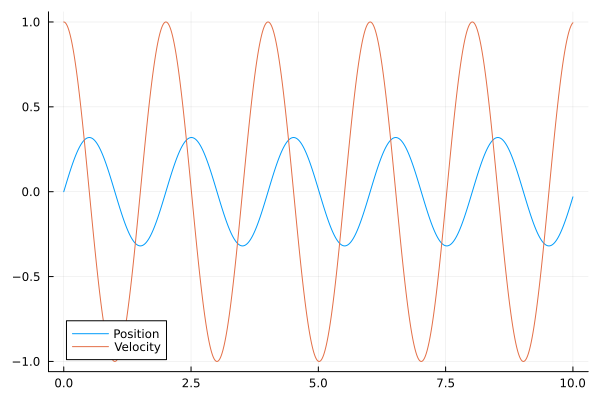

In [2]:
# Generate data from a known linear dynamical system--a pendulum
g = 9.81 # gravity
l = 1.0 # length of pendulum
dt = 0.001 # time step
T = 10.0 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 1.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end
# Plot data 
plot(t, x[1,:], label="Position")
plot!(t, x[2,:], label="Velocity")

In [3]:
# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 0.00001 * I(2)  # Process noise covariance
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
P0 = 0.1*I(2)  # Initial state covariance
x0 = [0.0; 1.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([false, false, false, false, false, false, false, false]))

# Run the Kalman filter
x_pred, P, v, F, K = KalmanFilter(kf, Matrix{Float64}(x_noisy'))

# Run the smoother
x_smooth, P_smooth = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

[0.000999998365000802, 0.9999950950040097]

([0.0 1.0; -0.03903761899562384 1.125548935910253; … ; -0.006653336426269763 0.9272039146486215; -0.003362430265472964 0.9284284535393046], [0.1 0.0; 0.07143209255666053 -0.00044945405318234715; … ; 0.0012801163522958236 -0.0007003129903726155; 0.0012801163522958236 -0.0007003129903726155;;; 0.0 0.1; -0.00044945405318234715 0.0714369511708631; … ; -0.0007003129903726155 0.002325312255325022; -0.0007003129903726155 0.002325312255325022])

In [4]:
SSM.loglikelihood(kf, Matrix{Float64}(x_noisy'))

-14549.930413606467

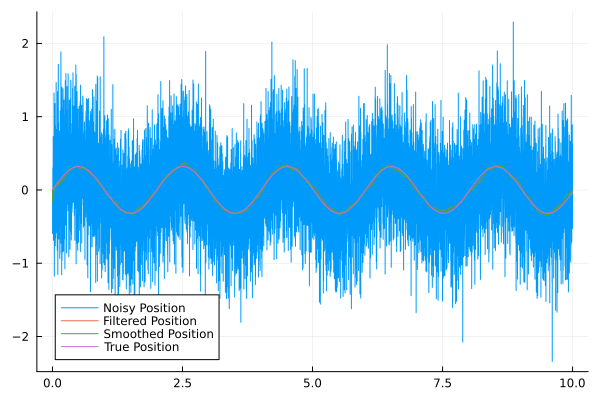

In [8]:
# plot the results
plot(t, x_noisy[1, :], label="Noisy Position")
plot!(t, x_pred[:, 1], label="Filtered Position")
plot!(t, x_smooth[:, 1], label="Smoothed Position")
plot!(t, x[1, :], label="True Position")
